In [34]:
import json
import os
import pandas as pd
import pprint
import time
import numpy as np

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping


try:
  from pyforest import *
except:
  !pip install pyforest
  from pyforest import *

print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17606227924560250543
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5251754991422357186
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5543214106052037803
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11158716416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17988927472704402803
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


## ConvLSTM Encoder-Decoder Model With Univariate Input

In [21]:
#from google.colab import files

#uploaded = files.upload()

!wget https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/dumps/q_p_list.pickle
    
with open("q_p_list.pickle", "rb") as infile:
  S=pickle.load(infile)
!rm q_p_list.pickle
S1=S[1]
#S1.head()

S1=pd.Series(S1)
S_series=[pd.Series(elem) for elem in S]
scaler = MinMaxScaler(feature_range=(0,1))
S1 = scaler.fit_transform(S1.values.reshape(-1,1))

S=[scaler.fit_transform(S1.values.reshape(-1,1)) for S1 in S_series]

#plt.plot(S1)
X_train, X_test, y_train, y_test = train_test_split(S1[:-1], S1[1:], test_size=0.33, random_state=None, shuffle=False)

--2019-09-05 11:47:50--  https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/dumps/q_p_list.pickle
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11150446 (11M) [application/octet-stream]
Saving to: ‘q_p_list.pickle’

q_p_list.pickle     100%[===================>]  10.63M  --.-KB/s    in 0.08s   

2019-09-05 11:47:50 (126 MB/s) - ‘q_p_list.pickle’ saved [11150446/11150446]



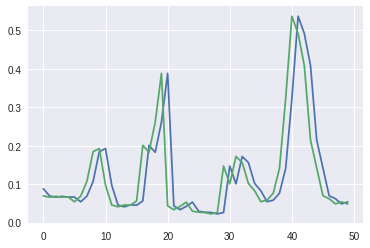

In [22]:
plt.plot(X_train[:50])
plt.plot(y_train[:50])

In [0]:
#Callback function for online plot while fitting

from IPython.display import clear_output


class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        n_step=100
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses)%n_step==0:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [0]:
def split_multi_sequence(seq_list, n_steps, n_target_serie):
    main_X, main_y, X, y = list(), list(), list(),list()
    target_seq=seq_list[n_target_serie]
    append=True
    for i in range(len(target_seq)):
        X=[]
        for sequence in seq_list:
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                append=False
                break
            else:
                append=True
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], target_seq[end_ix]
            X.append(np.array(seq_x))
            y.append(seq_y)
        if append==True:
            main_X.append(np.array(X))
            main_y.append(seq_y)
    #return np.array(X), np.array(y)
    return main_X, main_y

In [0]:
def shaper(X):
    arr=np.ndarray(shape=(len(X),X[0].shape[1],X[0].shape[0]))
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            for k in range(arr.shape[2]):
                    try:
                        arr[i][j][k]=X[i][k][j]
                    except Exception as e:
                        print(e)
                        print(i,j,k)
                        #break
    return arr

In [0]:
# choose a number of time steps
n_steps = 24
n_target_serie=0
# split into samples
X, y = split_multi_sequence([elem[:-100] for elem in S], n_steps,n_target_serie)
# reshape from [samples, timesteps] into [samples, timesteps, features]
#X=np.ndarray(X, shape=(len(X), X[0].shape[1], len(X)))

n_features = 51
#X = X.reshape((X.shape[0], X.shape[1], n_features))
#X = X.reshape((X.shape[0], X[0].shape[1], n_features))
X=shaper(X)
y=np.array(y)
#X
#y[0]

Xt, yt=split_multi_sequence([elem[-100:] for elem in S], n_steps, n_target_serie)
Xt=shaper(Xt)
#Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
#yt=S1[-100+1:]

In [0]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features),return_sequences=True))
#model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(LSTM(units=30, activation='relu'))
model.add(Dense(units=128))
model.add(Dense(units=1))
#model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())#, metrics=["acc"])
model.compile(loss='mean_squared_error', optimizer="adam")#, metrics=["acc"])

# fit model

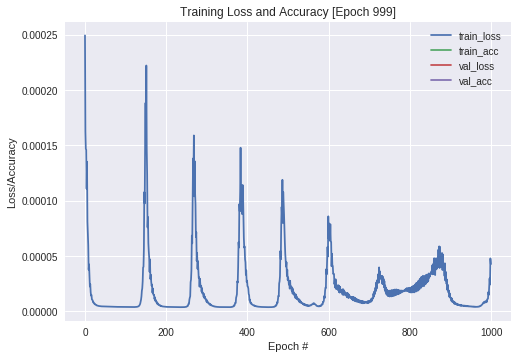

In [59]:
model.fit(X, y, epochs=1000, batch_size=1024, verbose=0,shuffle=False, callbacks=[plot_losses])#EarlyStopping(monitor='val_loss', patience=50)])
#model.fit(X, y, epochs=2000, verbose=0,shuffle=False,validation_split=0.2,callbacks=[plot_losses, EarlyStopping(monitor='val_loss', patience=100)])

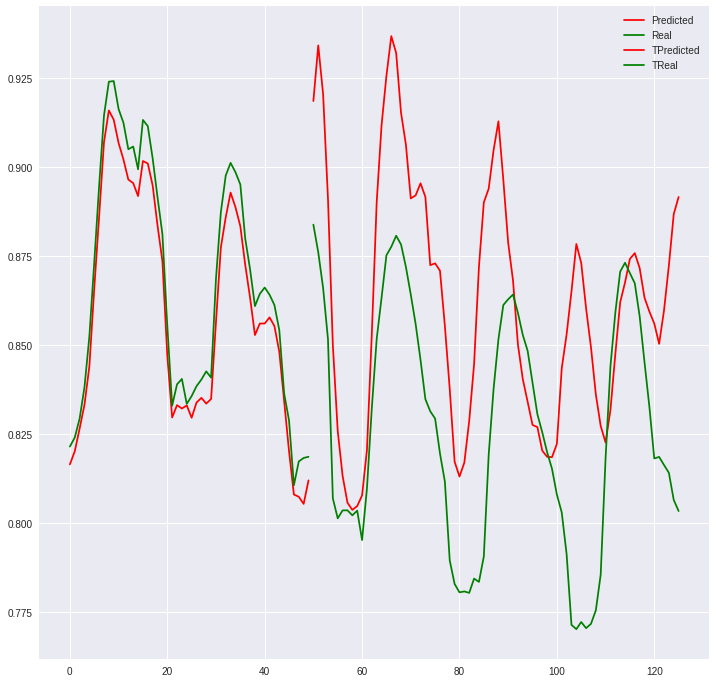

In [61]:
n_test=None
ypt = model.predict(Xt[:n_test], verbose=0)
yrt = yt[:n_test]

yp = model.predict(X[50:100], verbose=0)
yr = y[50:100]


plt.figure(figsize=(12,12))
n=100
plt.plot(yp, color= 'red', label="Predicted")
plt.plot(yr, color='green', label="Real")

plt.plot(range(len(yp),len(yp)+len(ypt)),ypt,color="red", label="TPredicted")
plt.plot(range(len(yp),len(yp)+len(yrt)),yrt,color="green",  label="TReal")

plt.legend()
plt.show()

In [0]:
for i in range(10):
    print(Xt[i,23], yt[i], yhat[i])


[0.33648097] [0.28853552] [0.35829258]
[0.28853552] [0.23944196] [0.30902788]
[0.23944196] [0.32168729] [0.26010272]
[0.32168729] [0.35129762] [0.3340825]
[0.35129762] [0.23887543] [0.37259173]
[0.23887543] [0.22539468] [0.26606396]
[0.22539468] [0.22632966] [0.24398328]
[0.22632966] [0.21790811] [0.24568862]
[0.21790811] [0.2281814] [0.24088095]
[0.2281814] [0.23807118] [0.250365]


In [0]:
score, acc = model.evaluate(X[50:100], y[50:100],batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

50/50 [==============================] - 5s 98ms/step
Test score: 0.00605501833371818
Test accuracy: 0.0


In [65]:
from keras.models import model_from_json
save=True

colab=True
if colab:
  model_name="LSTM_multivar_unidim"
else:
  model_name="lstm_models/LSTM_multivar_unidim"
model_weights=model_name+"_weigths.h5"
    
if save:
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_weights)
    print("Saved model to disk")
    if colab:
        from google.colab import files
        files.download(model_name+".json")
        files.download(model_weights)

# later...
load=False
colab=False
if load:
  if colab:
    files.upload()
  json_file = open(model_name+".json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
  loaded_model.load_weights(model_weights)
  print("Loaded model from disk")

recompile=False
if recompile:
    loaded_model.compile(loss='mse', optimizer="adam")
    model=loaded_model

Saved model to disk
